In [39]:
import sys
import numpy as np
from numpy.random import choice
import random
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

In [40]:
class Individuo:
    def __init__(self, cidades):
        self.cidades = cidades
        self.cromossomo = self.inicializar_individuo()
        self.valor_objetivo = None
        self.aptidao = None
        self.calc_valor_objetivo()
        self.isok = True
        self.checkisok()
        
    def inicializar_individuo(self):
        """
        método para inicializacao de cada individuo. Cada cromossomo do indivíduo constará
        com uma lista aleatório de cidades, em que apenas a última cidade será repetida da primeira.
        """
        cromossomo = self.cidades.copy()
        np.random.shuffle(cromossomo)
        return_city = cromossomo[0]
        cromossomo.append(return_city)
        return cromossomo.copy()
    
    def calc_valor_objetivo(self):
        """
        método para calculo da aptidao e valor objetivo.
        """
        d_total = 0
        for c in range(1, len(self.cromossomo)):
            cromoi = self.cromossomo[c-1]
            xi = cromoi['x']
            yi = cromoi['y']
            
            cromof = self.cromossomo[c]
            xf = cromof['x']
            yf = cromof['y']
            
            d_total += np.sqrt(((xf - xi)**2 + (yf - yi)**2))
        
        self.valor_objetivo = d_total
        if d_total == 0:
            self.aptidao = sys.maxsize
        else:
            self.aptidao = 1 / d_total
        
        return self
    
    def checkisok(self):
        """
        checagem se a solução está coerente.
        """
        nomes = list(map(lambda x: x["nome"], self.cidades))
        nomes_no_cromossomo = list(map(lambda x: x["nome"], self.cromossomo))
        
        if len(nomes)+1 != len(nomes_no_cromossomo):
            self.isok = False
            print(len(nomes)+1, len(nomes_no_cromossomo))
            raise Exception("not ok - menos ou mais cidades do que deveria")
                
        for nome in nomes:
            if nome not in nomes_no_cromossomo:
                self.isok = False
                print(nome)
                raise Exception("not ok - cidade não encontrada")
                
        if self.isok == False:
            print(nomes_no_cromossomo)
        
    def mutar1(self, taxa_mutacao):
        """
        Primeiro operador de mutação, são feitos swaps nas posições das cidades, com a cidade anterior.
        não pode trocar a ultima cidade, a primeira pode.
        """
        for i in range(0, len(self.cromossomo) -1):            
            if taxa_mutacao > np.random.rand():
                citya = self.cromossomo[i-1]
                cityb = self.cromossomo[i]
                self.cromossomo[i] = citya
                self.cromossomo[i-1] = cityb
                
            self.cromossomo[-1] = self.cromossomo[0]
        
        self.checkisok()
        self.calc_valor_objetivo()
    
    def mutar2(self, taxa_mutacao):
        """
        Segundo operador de mutação, são feitos swaps com posições de cidades aleatoriamente.
        não pode trocar a ultima cidade, a primeira pode.
        """
        for i in range(0, len(self.cromossomo) -1):   
            if taxa_mutacao > np.random.rand():
                j = np.random.randint(1, len(self.cromossomo)-1)
                citya = self.cromossomo[j]
                cityb = self.cromossomo[i]
                self.cromossomo[i] = citya
                self.cromossomo[j] = cityb
                
            self.cromossomo[-1] = self.cromossomo[0]
        
        self.checkisok()
        self.calc_valor_objetivo()

In [41]:
class Populacao:
    def __init__(self, tam_populacao, taxa_mutacao, qtd_geracoes, cidades, mutar=1, cruzar=1):
        self.individuos = [Individuo(cidades) for _ in range(0, tam_populacao)]
        self.tam_populacao = tam_populacao
        self.taxa_mutacao = taxa_mutacao
        self.qtd_geracoes = qtd_geracoes
        self.cidades = cidades
        self.howtocruzar=cruzar
        self.howtomutar=mutar
        self.historico = []
        self.alltimeMelhor = None
    
    
    def mostrar_ind(self, ind):
        """
        mostrar um indivíduo
        """
        print("Valores: " + str(ind.cromossomo) +
              " | Valor objetivo: " + str(ind.valor_objetivo))
    
    def mostrar_populacao(self):
        """
        mostrar a população inteira
        """
        print("------------------------ População Inicial ------------------------")

        for ind in self.individuos:
            self.mostrar_ind(ind)

        print("-------------------------------------------------------------------")
    
    # Método que retorna o melhor indivíduo da população
    def get_melhor_ind(self):
        """
        retorna o melhor indivíduo da população
        """
        melhor_ind = None

        for ind in self.individuos:
            if melhor_ind is None or melhor_ind.aptidao < ind.aptidao:
                melhor_ind = ind

        return melhor_ind
                    
    def find_index(self, indv, cidade):
        """
        método utilizado para encontrar o index de uma cidade nos cromossomos de um indivíduo.
        """
        for index in range(0,len(indv.cromossomo)):
            if indv.cromossomo[index]["nome"] == cidade["nome"]:
                return index
        print("no index found")
        print(indv.cromossomo)
        print(cidade)
        raise Exception("No Index Found")
        
    def cruzamento(self, ind_1, ind_2):
        """
        Método geral de cruzamento
        """
        index1 = int(len(ind_1.cromossomo)/3)
        index2 = len(ind_1.cromossomo)
                     
        init_cruz = np.random.randint(1, index1)
        fim_cruz = np.random.randint(init_cruz+1, index2)
        
        ordem_nova = list(map(lambda x: x["nome"], ind_2.cromossomo[init_cruz:fim_cruz]))
        ordem_velha = list(map(lambda x: x["nome"], ind_1.cromossomo[init_cruz:fim_cruz]))
        
        if set(ordem_nova) == set(ordem_velha):
            ind_1.cromossomo[init_cruz:fim_cruz] = ind_2.cromossomo[init_cruz:fim_cruz].copy()
        
        novo_cromossomo = ind_1.cromossomo
        novo_ind = Individuo(self.cidades)
        novo_ind.cromossomo = novo_cromossomo
        novo_ind.calc_valor_objetivo()
        
        novo_ind.checkisok()

        return novo_ind

    def gerar_descendente(self, ind_1, ind_2, prob_cruz):
        """
        Método geral para geração de descendentes
        """
        ind_1.checkisok()
        ind_2.checkisok()
        
        if prob_cruz > np.random.rand():
            novo_ind = self.cruzamento(ind_1, ind_2)
        else:
            novo_ind = ind_1
            
        if self.howtomutar == 1:
            novo_ind.mutar1(self.taxa_mutacao)
        else:
            novo_ind.mutar2(self.taxa_mutacao)
            
        return novo_ind

    def reproducao1(self):
        """
        Reprodução por roleta.
        """
        descendentes = []
        soma_aptidoes = sum([ind.aptidao for ind in self.individuos])    
        distribuicao_probabilidade = [ind.aptidao / soma_aptidoes for ind in self.individuos]
        
        for _ in range(0, self.tam_populacao):
            [ind_1, ind_2] = choice(self.individuos, 2, p=distribuicao_probabilidade, replace=False)
            descendentes.append(self.gerar_descendente(ind_1, ind_2, 1))

        return descendentes
    
    def reproducao2(self):
        """
        Reprodução por torneio.
        """
        descendentes = []
        sorted_individuos = sorted(self.individuos, key=lambda x: x.valor_objetivo, reverse=False)        
        prob_cruz = 0
        for i in range(0, self.tam_populacao):
            i2 = i+1
            if i2 >= self.tam_populacao:
                i2 = self.tam_populacao-1
                
            [ind_1, ind_2] = choice(sorted_individuos, 2, replace=False)
            [ind_3, ind_4] = choice(sorted_individuos, 2, replace=False)
            
            if ind_1.aptidao > ind_2.aptidao:
                winner1 = ind_1
            else:
                winner1 = ind_2
            
            if ind_3.aptidao > ind_4.aptidao:
                winner2 = ind_3
            else:
                winner2 = ind_4
            
            descendentes.append(self.gerar_descendente(winner1, winner2, prob_cruz))
            prob_cruz += 1/self.tam_populacao
            
        return descendentes
    
    def reproducao3(self):
        """
        Reprodução por elitismo aleatorio.
        """
        descendentes = []
        sorted_individuos = sorted(self.individuos, key=lambda x: x.valor_objetivo, reverse=False)
        prob_cruz = 0
        for i in range(0, self.tam_populacao):
            if i < np.random.randint(1, self.tam_populacao):
                descendentes.append(sorted_individuos[i])
            
            else:
                i2 = i+1
                if i2 >= self.tam_populacao:
                    i2 = self.tam_populacao-1
                    
                [ind_1, ind_2] = [sorted_individuos[i], sorted_individuos[i2]]
                descendentes.append(self.gerar_descendente(ind_1, ind_2, prob_cruz))
                prob_cruz += 1/self.tam_populacao

        return descendentes
    
    def checkpopulation(self):
        """
        checa se toda a população está coerente
        """
        for ind in self.individuos:
            ind.checkisok()
    
    def train(self, verbose=False):
        """
        treinamento de fato
        """
        self.checkpopulation()
        
        for i in range(0, self.qtd_geracoes):
            genMelhor = self.get_melhor_ind()
            if self.alltimeMelhor is None or self.alltimeMelhor.aptidao < genMelhor.aptidao:
                self.alltimeMelhor = copy.copy(genMelhor)
        
            self.historico.append(self.alltimeMelhor)
            
            if verbose:
                print("\n------------------- Geração " + str(i + 1) + "-------------------")
                print("\n------------------- Melhor " + str(i + 1) + "-------------------")
                self.mostrar_ind(genMelhor)
            
            if self.howtocruzar == "roleta":
                descendentes = self.reproducao1()
            elif self.howtocruzar == "torneio":
                descendentes = self.reproducao2()
            elif self.howtocruzar == "elitismo":
                descendentes = self.reproducao3()
                            
            self.individuos = descendentes
            
            self.checkpopulation()

In [55]:
Cidades = [{"nome" : "Aflitos", "x":50, "y":60},
           {"nome" : "CasaAmarela", "x":140, "y":78},
           {"nome" : "CasaForte", "x":110, "y":55},
           {"nome" : "CampoGrande", "x":30, "y":108},
           {"nome" : "BoaViagem", "x":240, "y":378},
           {"nome" : "Piedade", "x":400, "y":128},
           {"nome" : "CidadeUni", "x":330, "y":256},
           {"nome" : "Derby", "x":80, "y":15},
           {"nome" : "Encruzilhada", "x":30, "y":20},
           {"nome" : "Ibura", "x":280, "y":12}]

tam_pop=1000
taxa_mut=0.5
qt_gen = 50
xticks = np.arange(1, qt_gen+1,1)

## Teste Cruzar roleta - Mutar1

In [56]:
populacao_t1 = Populacao(tam_populacao=tam_pop, taxa_mutacao=taxa_mut, qtd_geracoes=qt_gen,
                         cidades=Cidades,mutar=1, cruzar="roleta")
#populacao.mostrar_populacao()
populacao_t1.train()

populacao_t1.mostrar_ind(populacao_t1.alltimeMelhor)

Valores: [{'nome': 'BoaViagem', 'x': 240, 'y': 378}, {'nome': 'Ibura', 'x': 280, 'y': 12}, {'nome': 'Encruzilhada', 'x': 30, 'y': 20}, {'nome': 'Piedade', 'x': 400, 'y': 128}, {'nome': 'CasaForte', 'x': 110, 'y': 55}, {'nome': 'CampoGrande', 'x': 30, 'y': 108}, {'nome': 'Derby', 'x': 80, 'y': 15}, {'nome': 'CasaAmarela', 'x': 140, 'y': 78}, {'nome': 'CidadeUni', 'x': 330, 'y': 256}, {'nome': 'Aflitos', 'x': 50, 'y': 60}, {'nome': 'BoaViagem', 'x': 240, 'y': 378}] | Valor objetivo: 1290.7429904401765


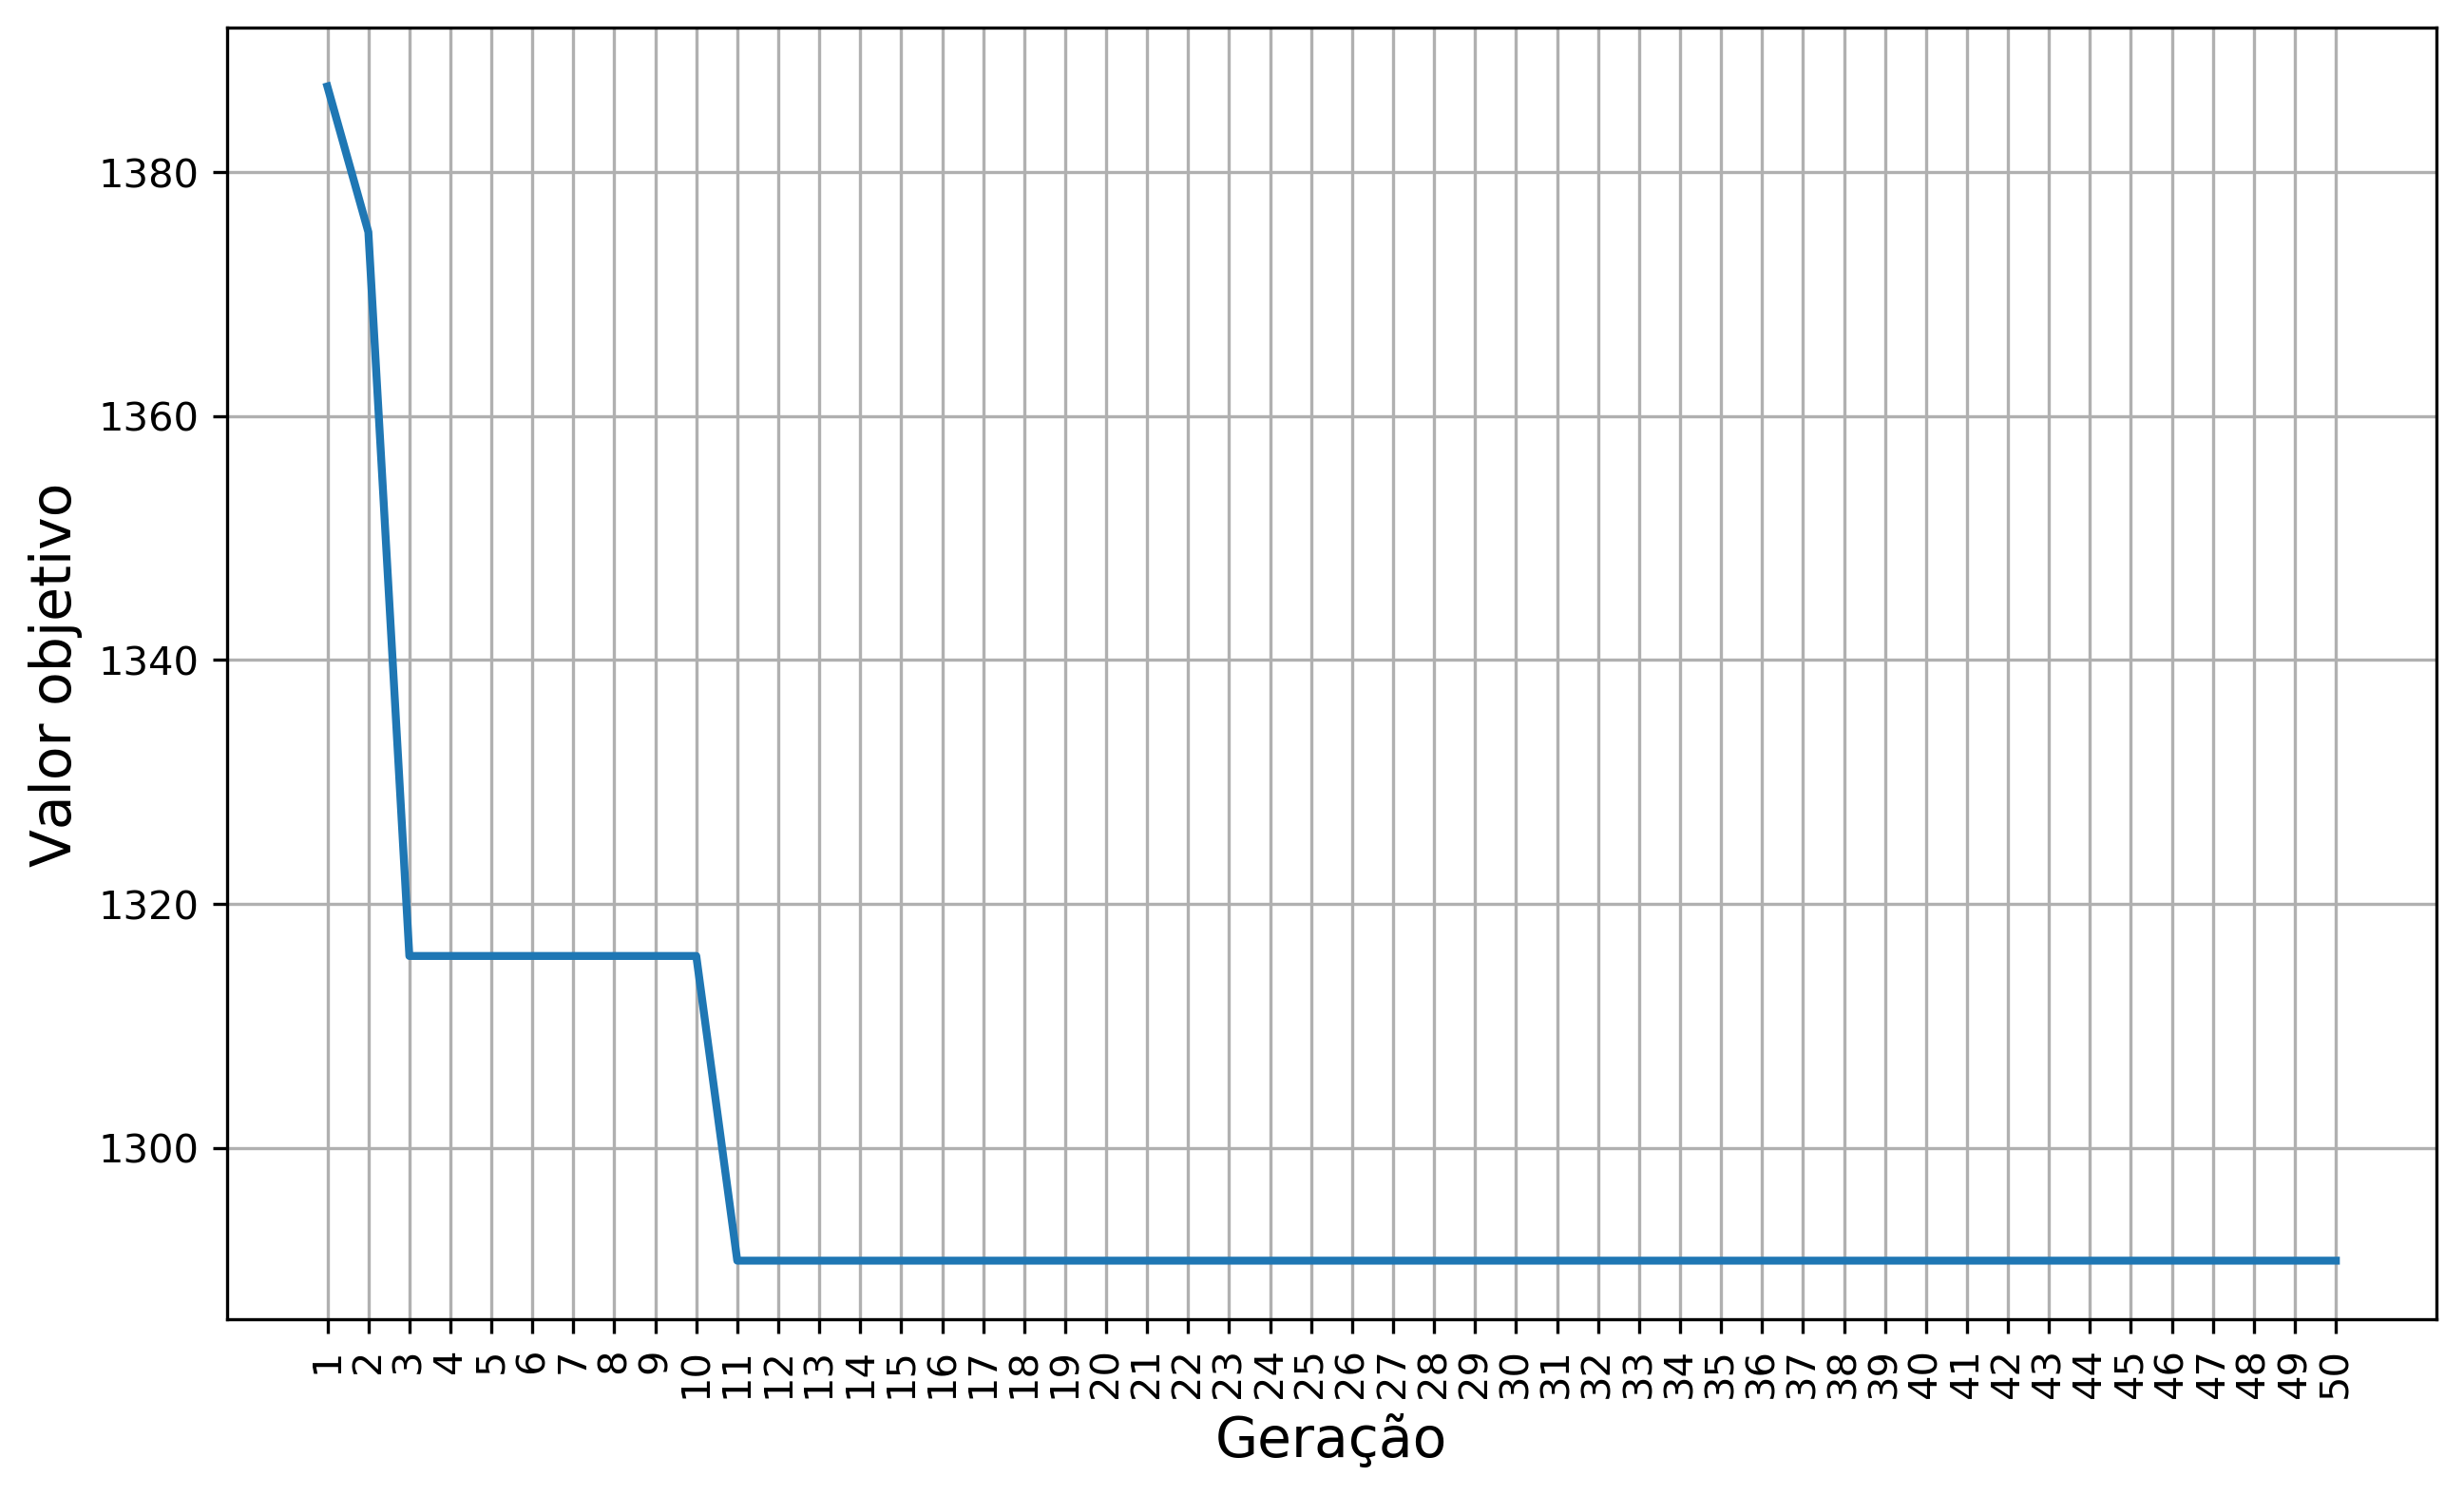

In [57]:
hist_fit_t1 = list(map(lambda x: x.valor_objetivo, populacao_t1.historico))
fig= plt.figure(figsize=(10,6), dpi=300)
plt.plot(xticks, hist_fit_t1, linewidth=2)
plt.xlabel("Geração", fontsize=14)
plt.ylabel("Valor objetivo", fontsize=14)
plt.xticks(xticks, rotation=90)
plt.grid()

## Teste Cruzar torneio - Mutar1

In [58]:
populacao_t2 = Populacao(tam_populacao=tam_pop, taxa_mutacao=taxa_mut, qtd_geracoes=qt_gen,
                         cidades=Cidades,mutar=1, cruzar="torneio")
#populacao.mostrar_populacao()
populacao_t2.train()

populacao_t2.mostrar_ind(populacao_t2.alltimeMelhor)

Valores: [{'nome': 'Derby', 'x': 80, 'y': 15}, {'nome': 'CasaForte', 'x': 110, 'y': 55}, {'nome': 'Encruzilhada', 'x': 30, 'y': 20}, {'nome': 'CasaAmarela', 'x': 140, 'y': 78}, {'nome': 'CidadeUni', 'x': 330, 'y': 256}, {'nome': 'Piedade', 'x': 400, 'y': 128}, {'nome': 'BoaViagem', 'x': 240, 'y': 378}, {'nome': 'Ibura', 'x': 280, 'y': 12}, {'nome': 'Aflitos', 'x': 50, 'y': 60}, {'nome': 'CampoGrande', 'x': 30, 'y': 108}, {'nome': 'Derby', 'x': 80, 'y': 15}] | Valor objetivo: 1242.6821838294823


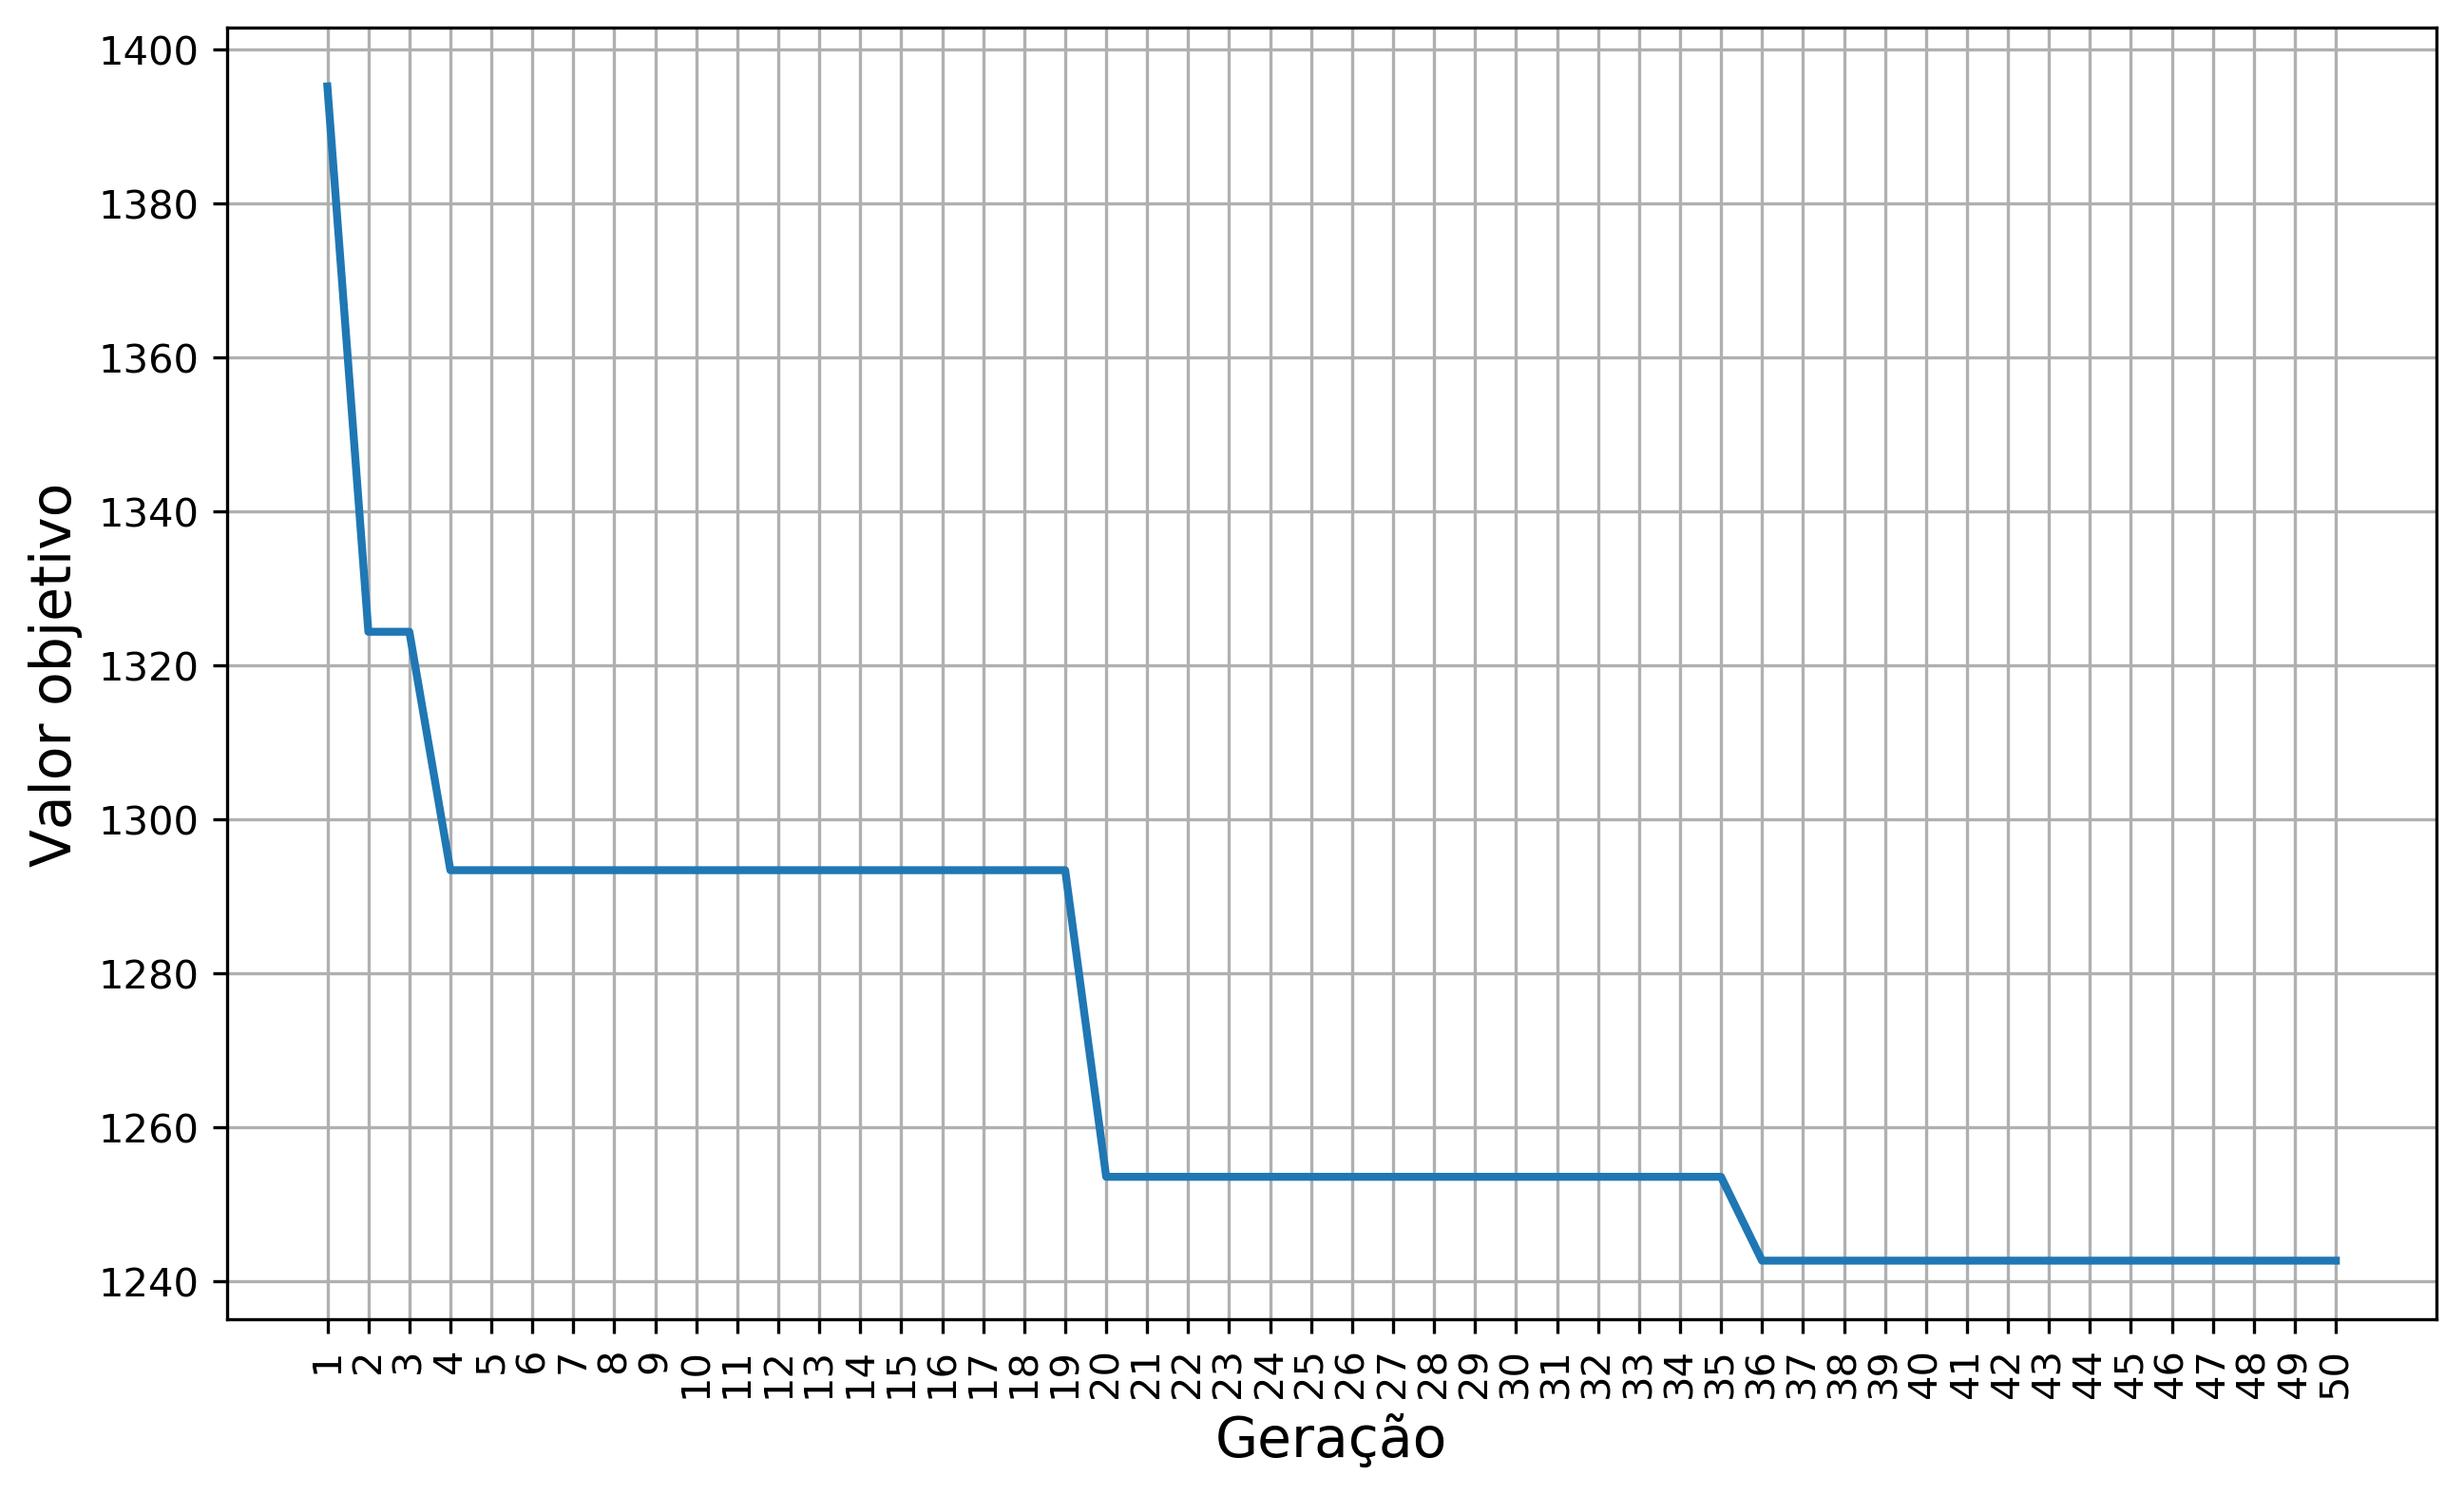

In [59]:
hist_fit_t2 = list(map(lambda x: x.valor_objetivo, populacao_t2.historico))
fig= plt.figure(figsize=(10,6), dpi=300)
plt.plot(xticks, hist_fit_t2, linewidth=2)
plt.xlabel("Geração", fontsize=14)
plt.ylabel("Valor objetivo", fontsize=14)
plt.xticks(xticks, rotation=90)
plt.grid()

## Teste Cruzar elitismo - Mutar1

In [60]:
populacao_t3 = Populacao(tam_populacao=tam_pop, taxa_mutacao=taxa_mut, qtd_geracoes=qt_gen,
                         cidades=Cidades, mutar=1, cruzar="elitismo")
#populacao.mostrar_populacao()
populacao_t3.train()

populacao_t3.mostrar_ind(populacao_t3.alltimeMelhor)

Valores: [{'nome': 'Encruzilhada', 'x': 30, 'y': 20}, {'nome': 'Derby', 'x': 80, 'y': 15}, {'nome': 'CasaForte', 'x': 110, 'y': 55}, {'nome': 'Ibura', 'x': 280, 'y': 12}, {'nome': 'Piedade', 'x': 400, 'y': 128}, {'nome': 'CidadeUni', 'x': 330, 'y': 256}, {'nome': 'BoaViagem', 'x': 240, 'y': 378}, {'nome': 'CasaAmarela', 'x': 140, 'y': 78}, {'nome': 'CampoGrande', 'x': 30, 'y': 108}, {'nome': 'Aflitos', 'x': 50, 'y': 60}, {'nome': 'Encruzilhada', 'x': 30, 'y': 20}] | Valor objetivo: 1266.9662614218028


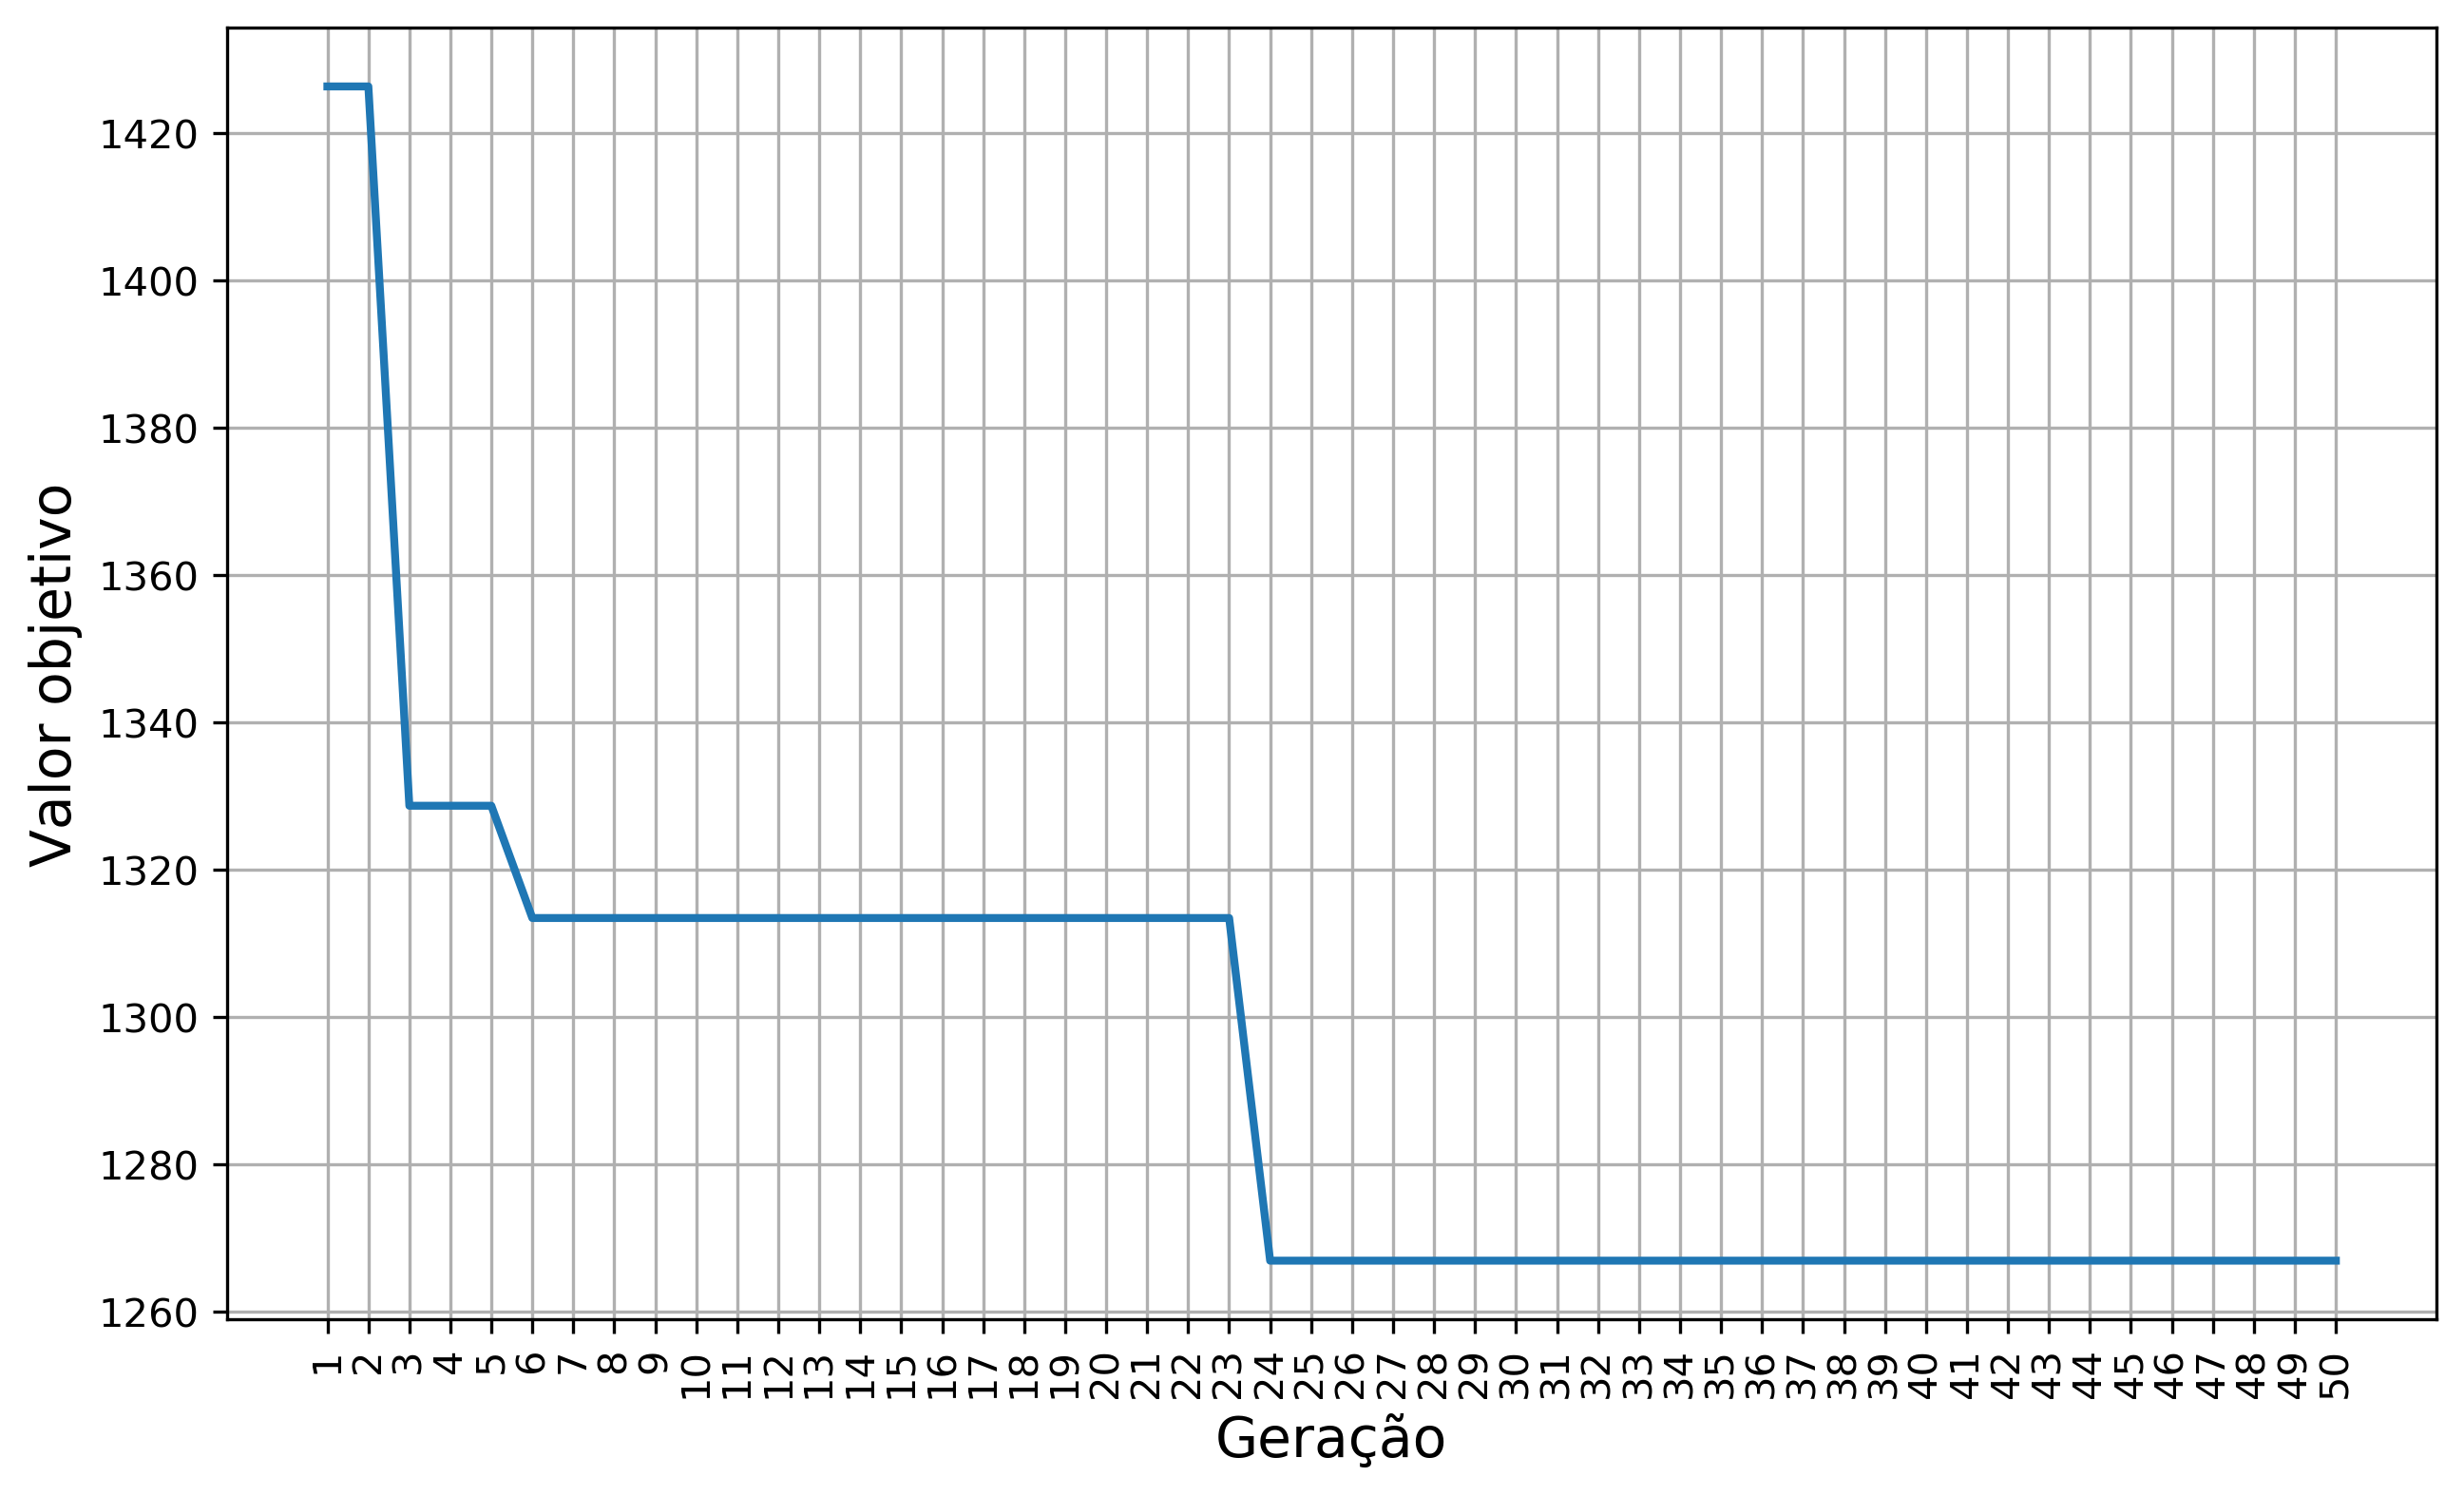

In [61]:
hist_fit_t3 = list(map(lambda x: x.valor_objetivo, populacao_t3.historico))
fig= plt.figure(figsize=(10,6), dpi=300)
plt.plot(xticks, hist_fit_t3, linewidth=2)
plt.xlabel("Geração", fontsize=14)
plt.ylabel("Valor objetivo", fontsize=14)
plt.xticks(xticks, rotation=90)
plt.grid()

## Teste Cruzar roleta - Mutar2

In [62]:
populacao_t4 = Populacao(tam_populacao=tam_pop, taxa_mutacao=taxa_mut, qtd_geracoes=qt_gen,
                         cidades=Cidades,mutar=2, cruzar="roleta")
#populacao.mostrar_populacao()
populacao_t4.train()

populacao_t4.mostrar_ind(populacao_t4.alltimeMelhor)

Valores: [{'nome': 'BoaViagem', 'x': 240, 'y': 378}, {'nome': 'CidadeUni', 'x': 330, 'y': 256}, {'nome': 'CasaForte', 'x': 110, 'y': 55}, {'nome': 'Encruzilhada', 'x': 30, 'y': 20}, {'nome': 'Piedade', 'x': 400, 'y': 128}, {'nome': 'CampoGrande', 'x': 30, 'y': 108}, {'nome': 'Ibura', 'x': 280, 'y': 12}, {'nome': 'CasaAmarela', 'x': 140, 'y': 78}, {'nome': 'Derby', 'x': 80, 'y': 15}, {'nome': 'Aflitos', 'x': 50, 'y': 60}, {'nome': 'BoaViagem', 'x': 240, 'y': 378}] | Valor objetivo: 1251.568910740579


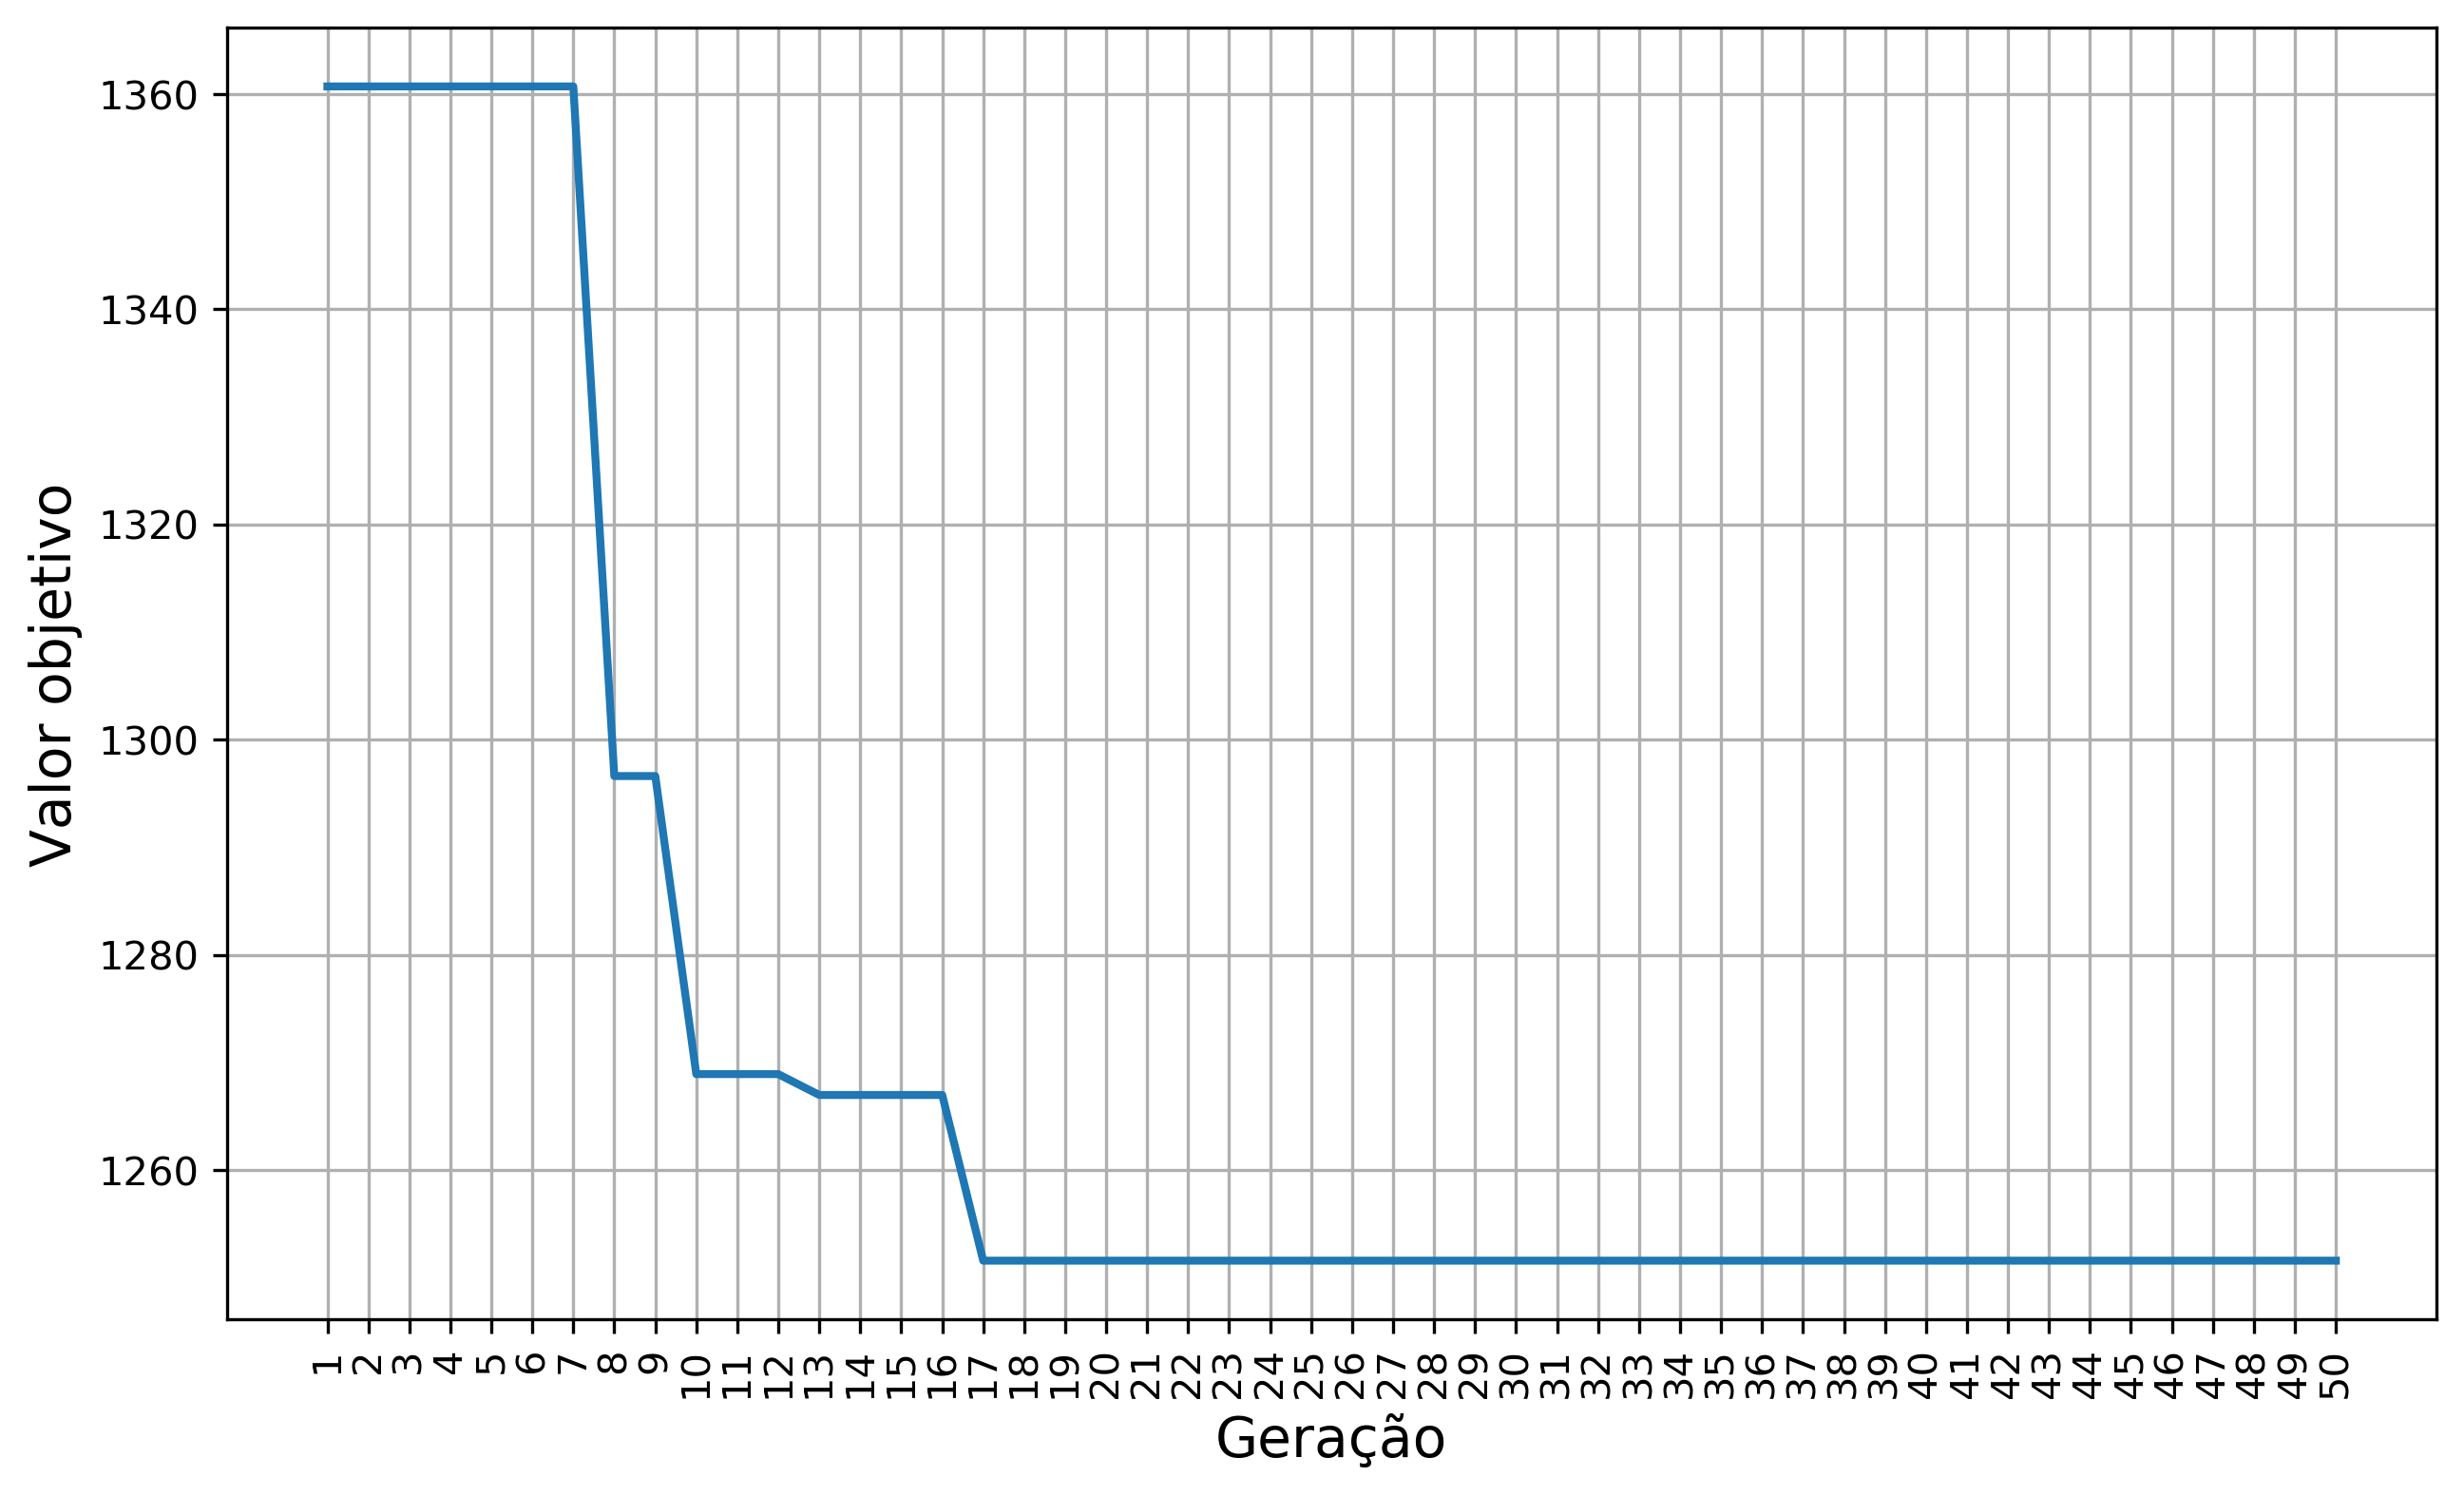

In [63]:
hist_fit_t4 = list(map(lambda x: x.valor_objetivo, populacao_t4.historico))
fig= plt.figure(figsize=(10,6), dpi=300)
plt.plot(xticks, hist_fit_t4, linewidth=2)
plt.xlabel("Geração", fontsize=14)
plt.ylabel("Valor objetivo", fontsize=14)
plt.xticks(xticks, rotation=90)
plt.grid()

## Teste Cruzar torneio - Mutar2

In [64]:
populacao_t5 = Populacao(tam_populacao=tam_pop, taxa_mutacao=taxa_mut, qtd_geracoes=qt_gen,
                         cidades=Cidades, mutar=2, cruzar="torneio")
#populacao.mostrar_populacao()
populacao_t5.train()

populacao_t5.mostrar_ind(populacao_t5.alltimeMelhor)

Valores: [{'nome': 'Derby', 'x': 80, 'y': 15}, {'nome': 'Encruzilhada', 'x': 30, 'y': 20}, {'nome': 'CasaAmarela', 'x': 140, 'y': 78}, {'nome': 'Ibura', 'x': 280, 'y': 12}, {'nome': 'CampoGrande', 'x': 30, 'y': 108}, {'nome': 'Aflitos', 'x': 50, 'y': 60}, {'nome': 'CasaForte', 'x': 110, 'y': 55}, {'nome': 'BoaViagem', 'x': 240, 'y': 378}, {'nome': 'Piedade', 'x': 400, 'y': 128}, {'nome': 'CidadeUni', 'x': 330, 'y': 256}, {'nome': 'Derby', 'x': 80, 'y': 15}] | Valor objetivo: 1235.8329192910091


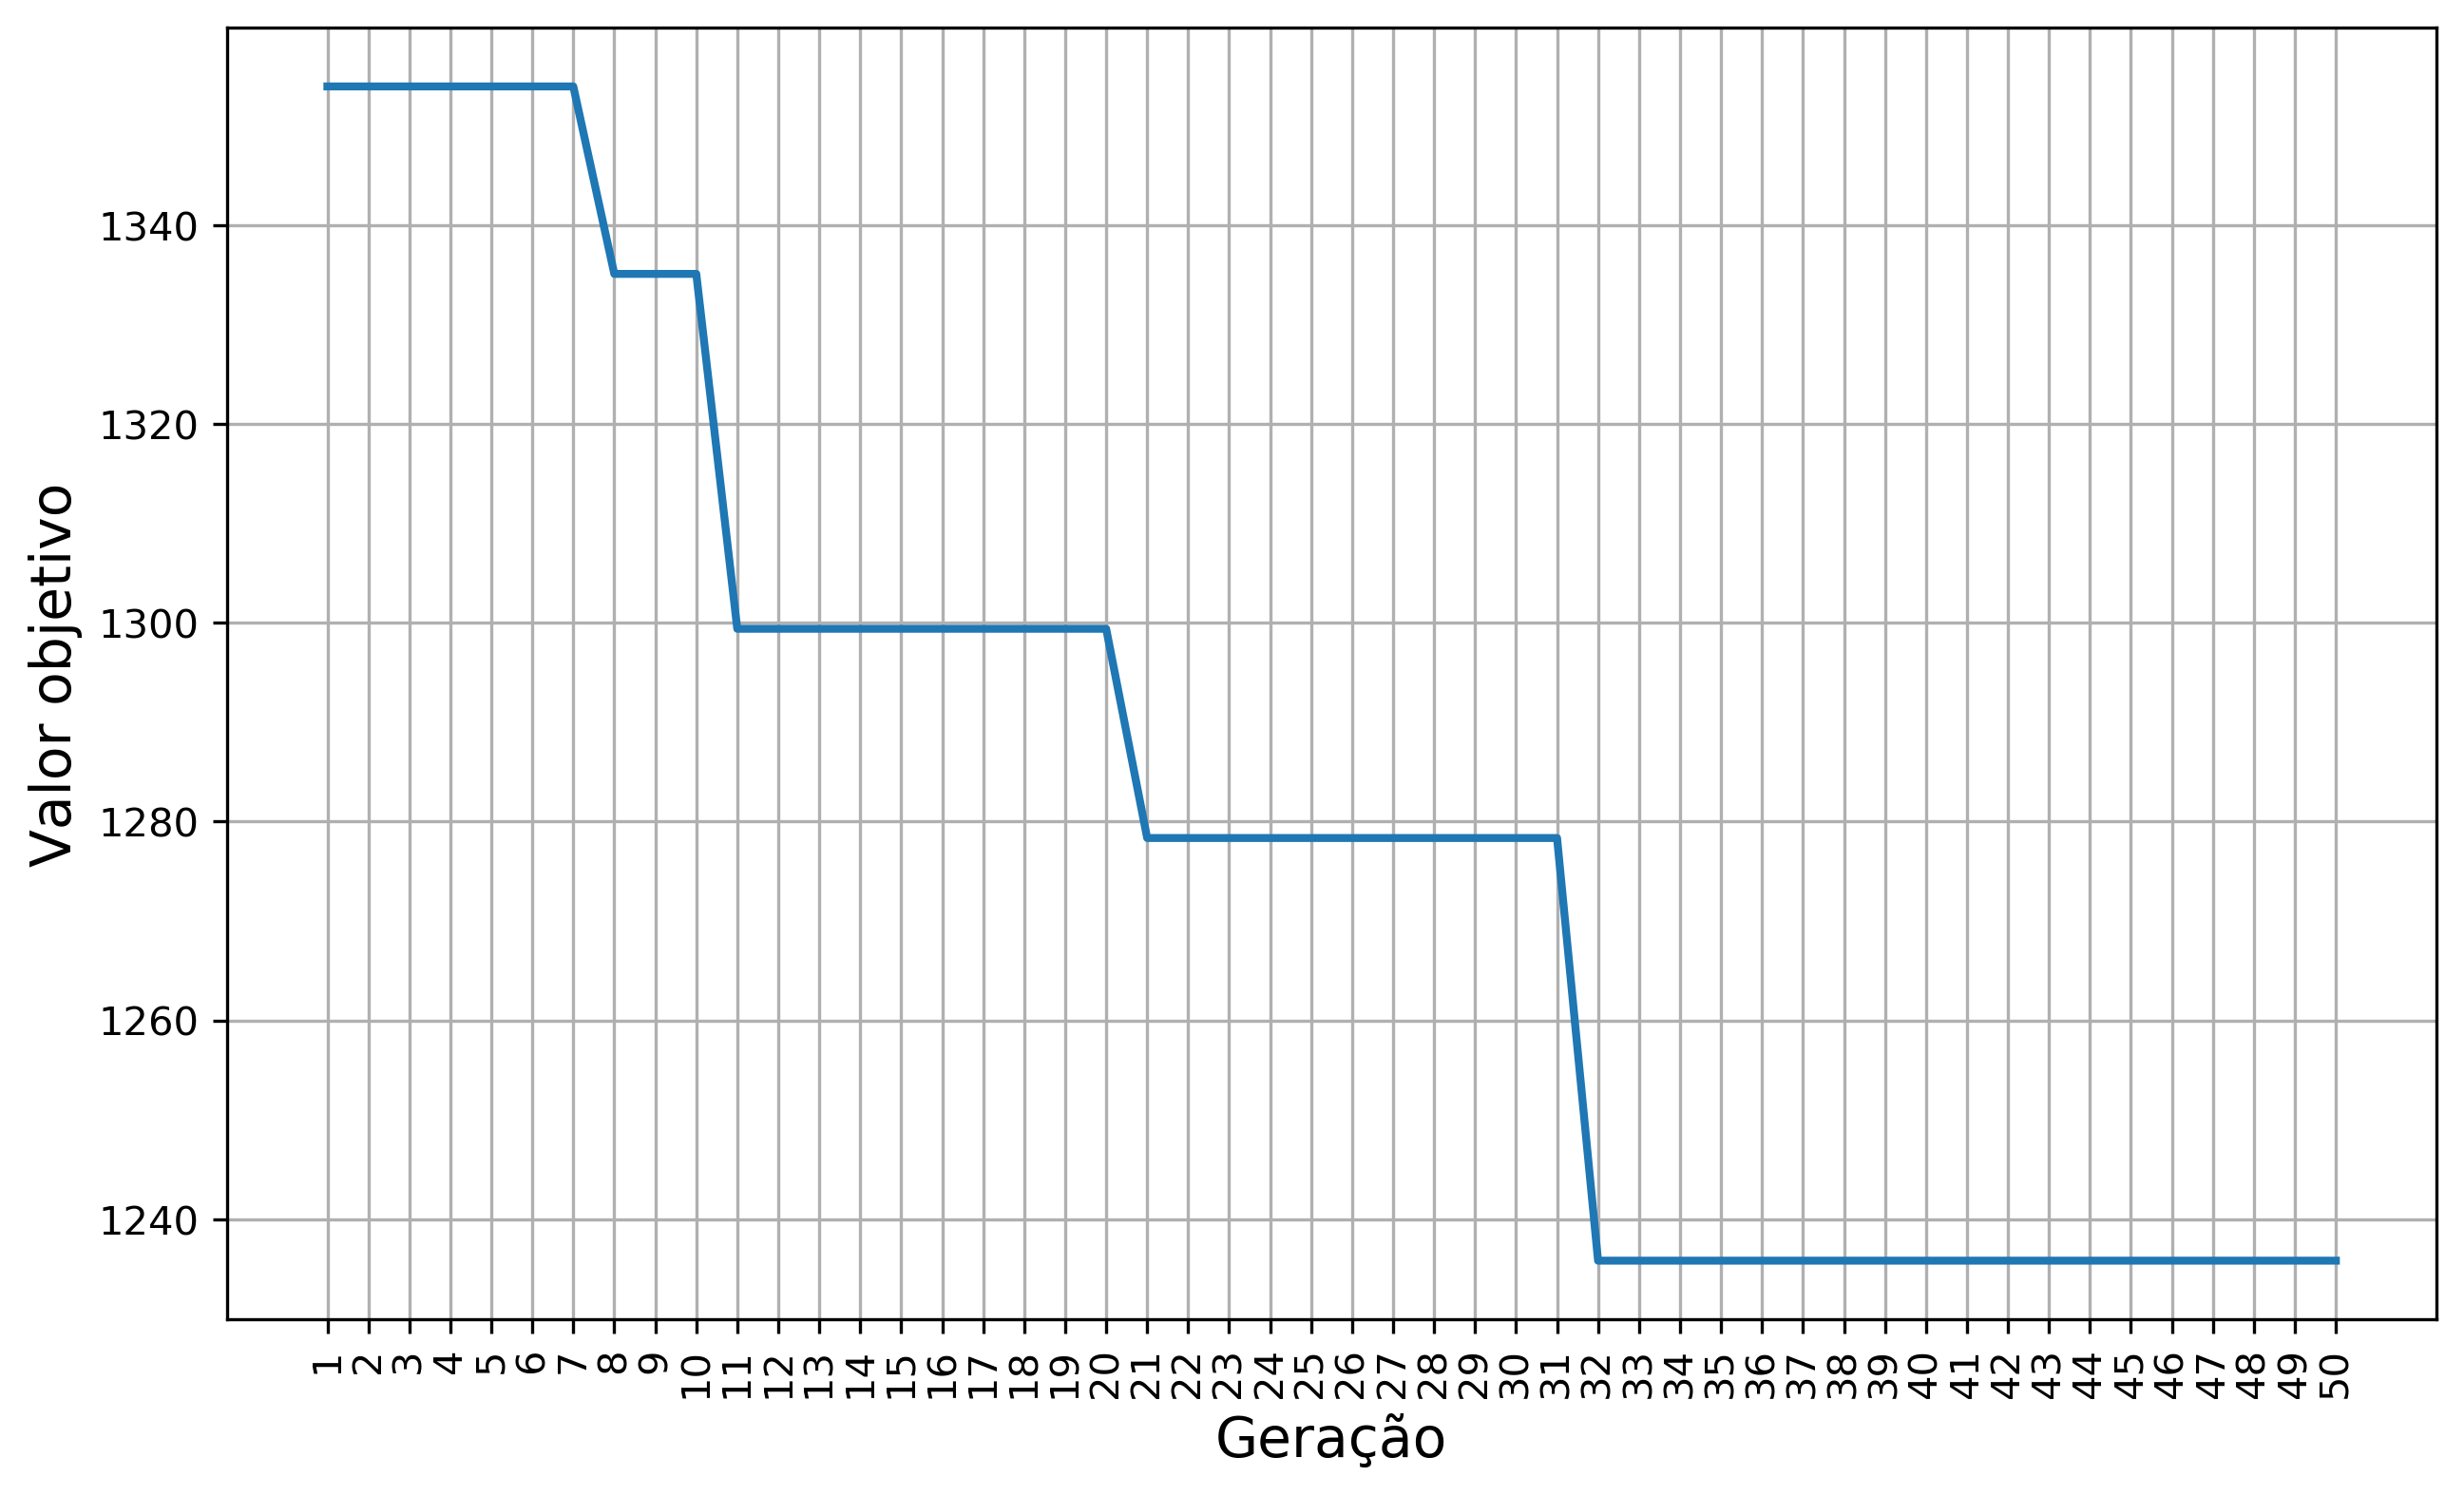

In [65]:
hist_fit_t5 = list(map(lambda x: x.valor_objetivo, populacao_t5.historico))
fig= plt.figure(figsize=(10,6), dpi=300)
plt.plot(xticks, hist_fit_t5, linewidth=2)
plt.xlabel("Geração", fontsize=14)
plt.ylabel("Valor objetivo", fontsize=14)
plt.xticks(xticks, rotation=90)
plt.grid()

## Teste Cruzar elitismo - Mutar2

In [66]:
populacao_t6 = Populacao(tam_populacao=tam_pop, taxa_mutacao=taxa_mut, qtd_geracoes=qt_gen,
                         cidades=Cidades,mutar=2, cruzar="elitismo")
#populacao.mostrar_populacao()
populacao_t6.train()

populacao_t6.mostrar_ind(populacao_t6.alltimeMelhor)

Valores: [{'nome': 'BoaViagem', 'x': 240, 'y': 378}, {'nome': 'CasaAmarela', 'x': 140, 'y': 78}, {'nome': 'CasaForte', 'x': 110, 'y': 55}, {'nome': 'CampoGrande', 'x': 30, 'y': 108}, {'nome': 'Aflitos', 'x': 50, 'y': 60}, {'nome': 'Encruzilhada', 'x': 30, 'y': 20}, {'nome': 'Derby', 'x': 80, 'y': 15}, {'nome': 'Ibura', 'x': 280, 'y': 12}, {'nome': 'Piedade', 'x': 400, 'y': 128}, {'nome': 'CidadeUni', 'x': 330, 'y': 256}, {'nome': 'BoaViagem', 'x': 240, 'y': 378}] | Valor objetivo: 1261.3829409157677


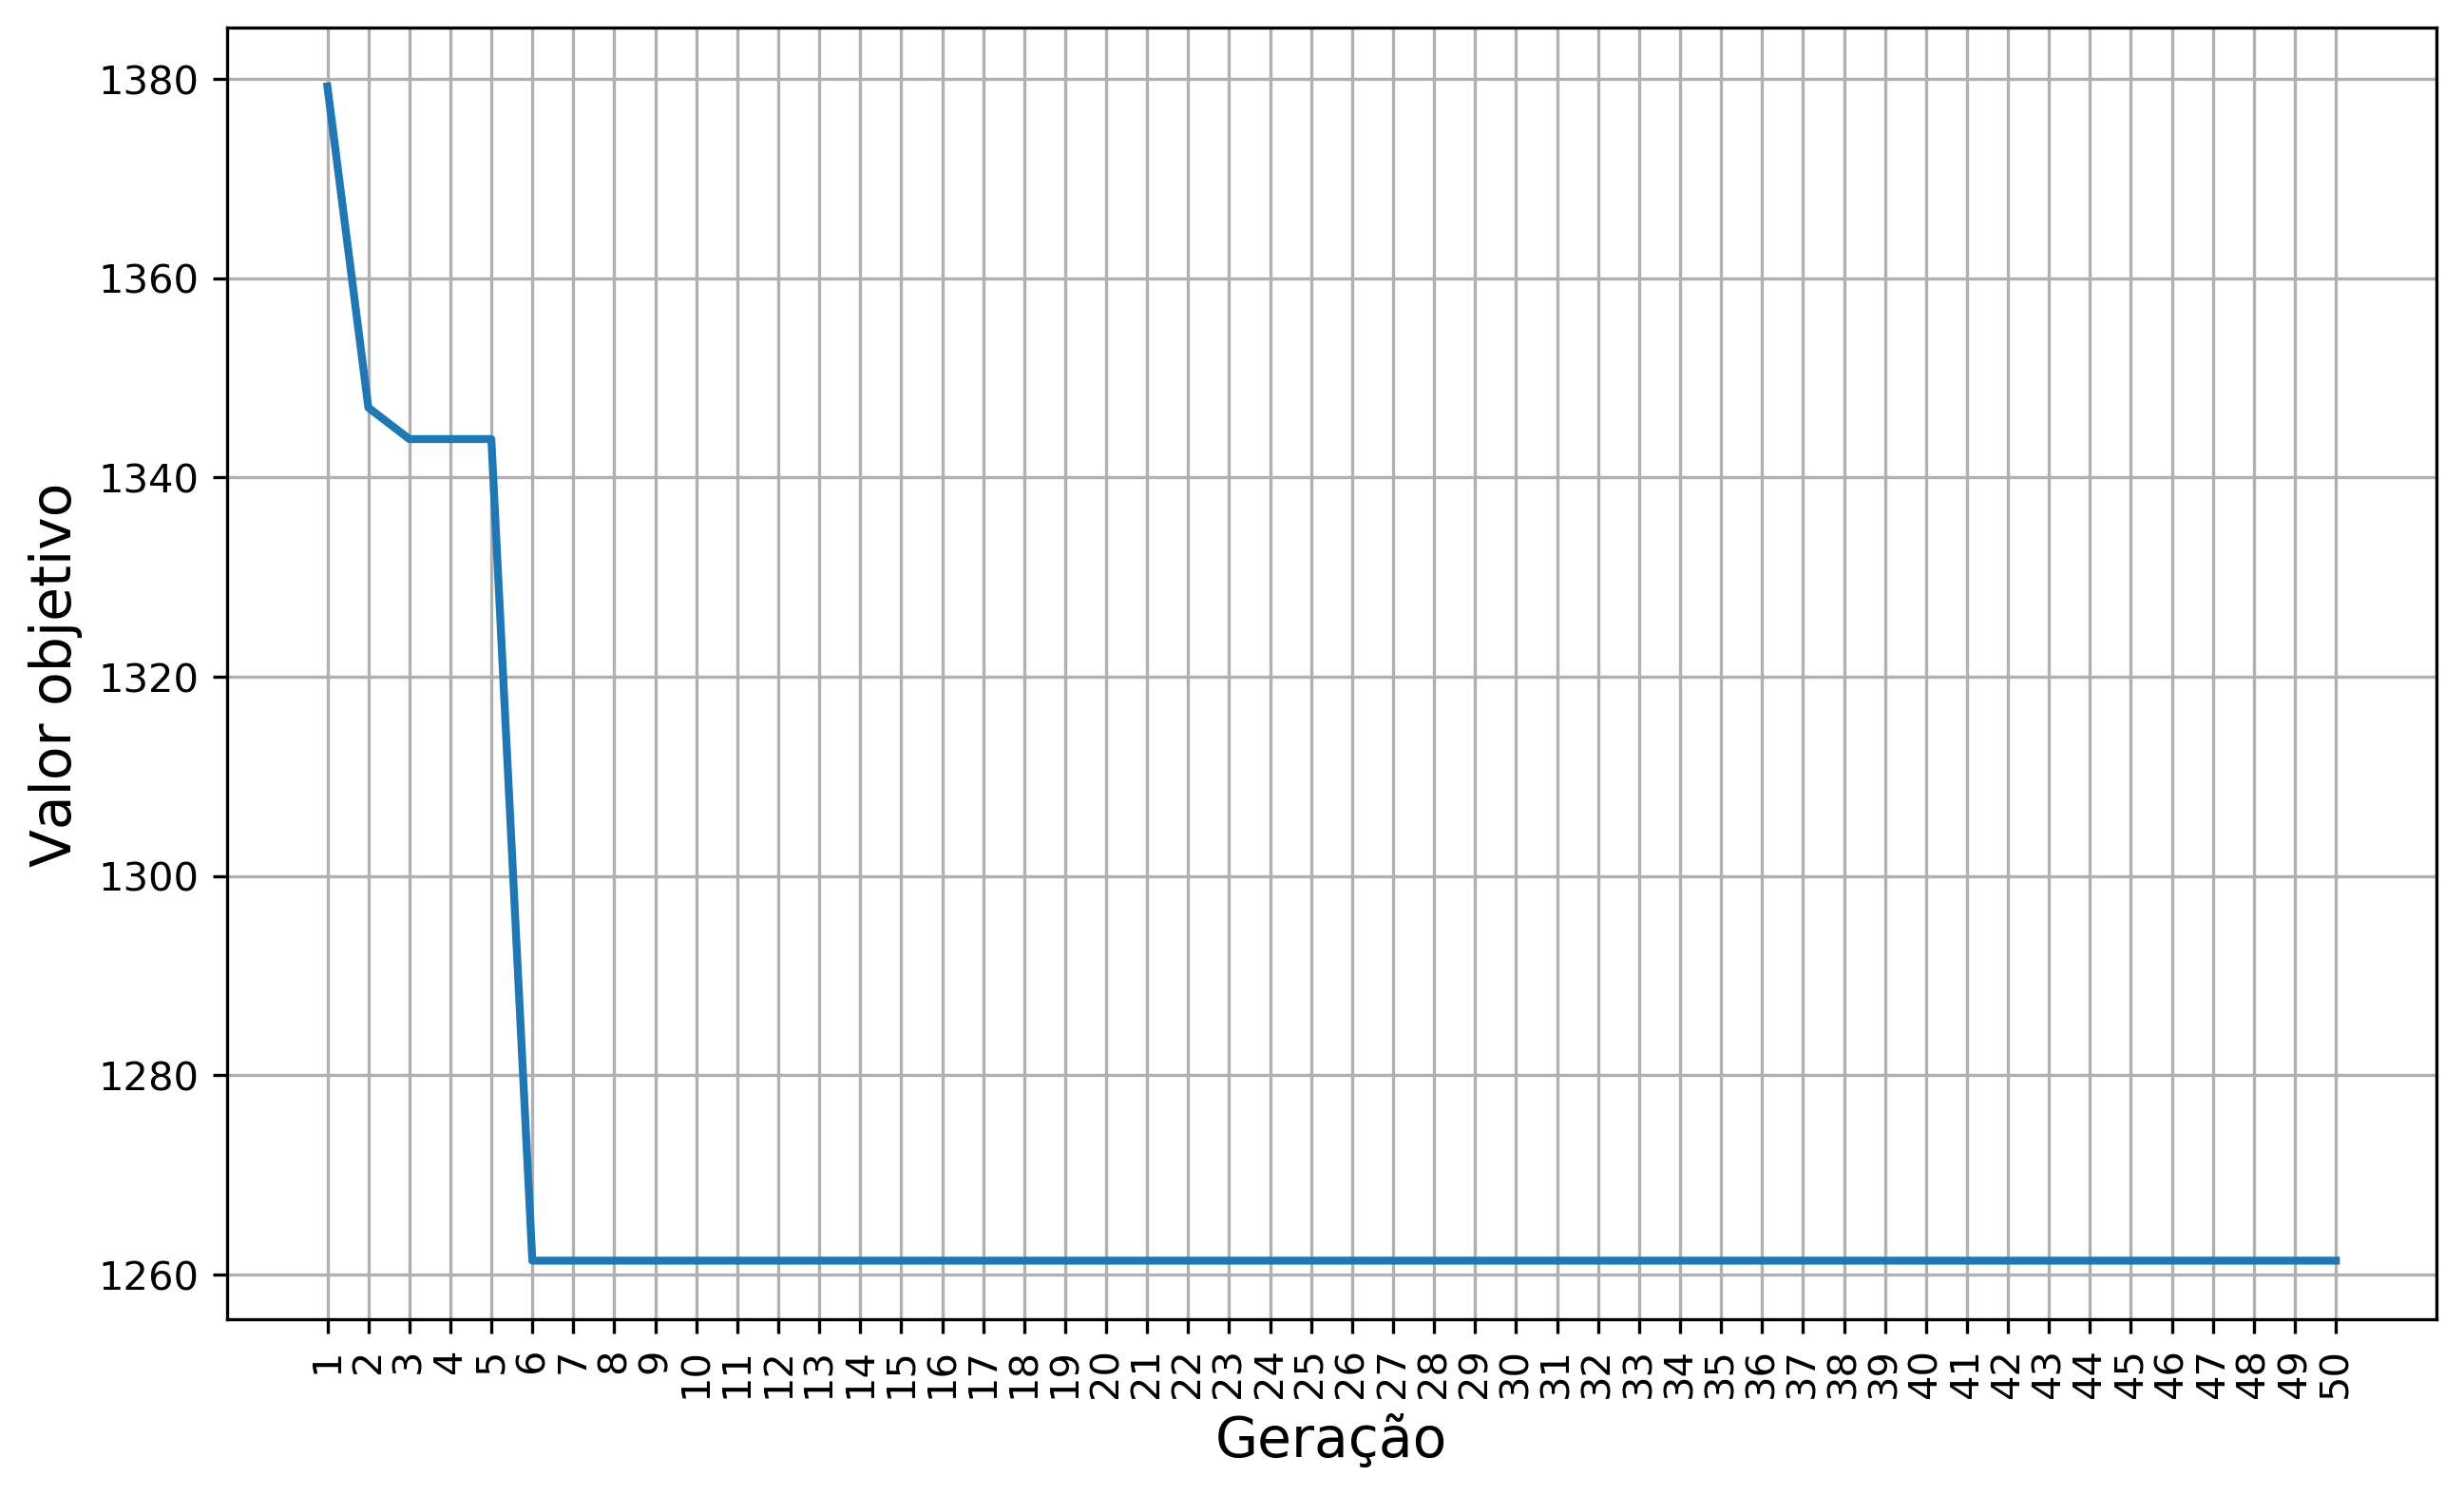

In [67]:
hist_fit_t6 = list(map(lambda x: x.valor_objetivo, populacao_t6.historico))
fig= plt.figure(figsize=(10,6), dpi=300)
plt.plot(xticks, hist_fit_t6, linewidth=2)
plt.xlabel("Geração", fontsize=14)
plt.ylabel("Valor objetivo", fontsize=14)
plt.xticks(xticks, rotation=90)
plt.grid()

## Um grafico

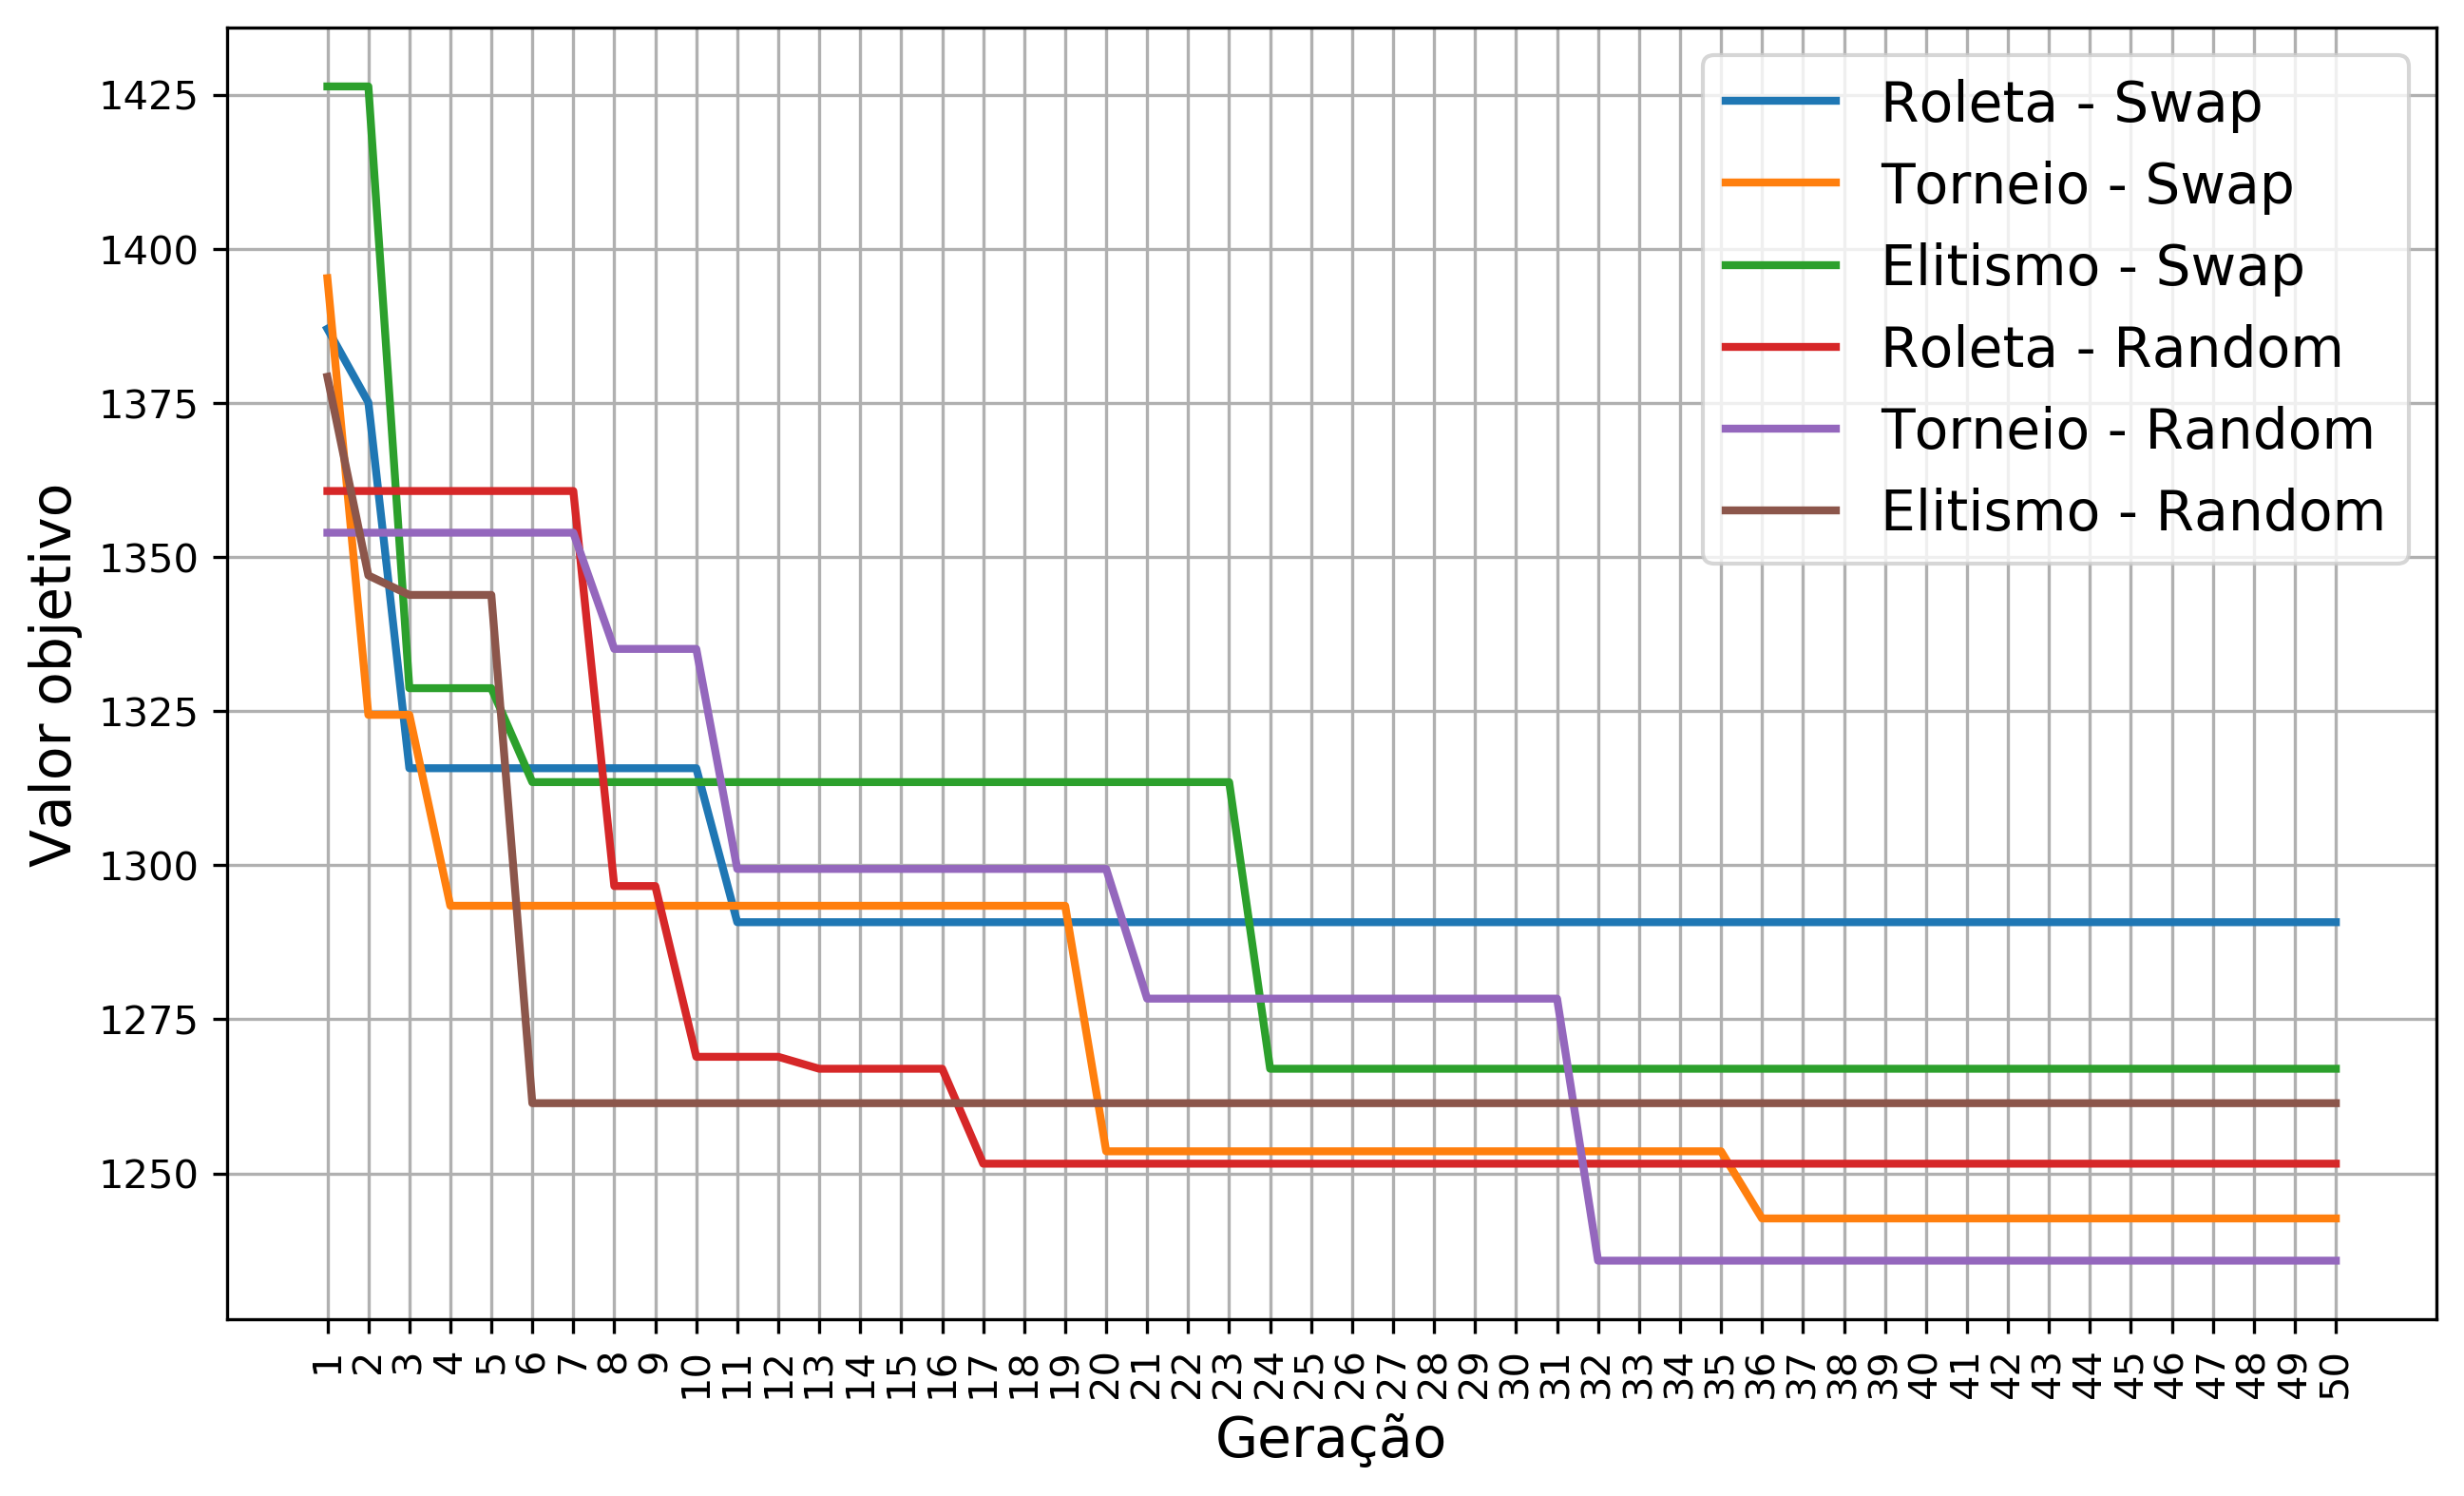

In [70]:
fig= plt.figure(figsize=(10,6), dpi=300)

plt.plot(xticks, hist_fit_t1, linewidth=2, label="Roleta - Swap")
plt.plot(xticks, hist_fit_t2, linewidth=2, label="Torneio - Swap")
plt.plot(xticks, hist_fit_t3, linewidth=2, label="Elitismo - Swap")
plt.plot(xticks, hist_fit_t4, linewidth=2, label="Roleta - Random")
plt.plot(xticks, hist_fit_t5, linewidth=2, label="Torneio - Random")
plt.plot(xticks, hist_fit_t6, linewidth=2, label="Elitismo - Random")

plt.legend(fontsize=14)
plt.xlabel("Geração", fontsize=14)
plt.ylabel("Valor objetivo", fontsize=14)
plt.xticks(xticks, rotation=90)
plt.grid()

# Solução combinatorial

In [35]:
import itertools

Cidades = [{"nome" : "Aflitos", "x":50, "y":60},
           {"nome" : "CasaAmarela", "x":140, "y":78},
           {"nome" : "CasaForte", "x":110, "y":55},
           {"nome" : "CampoGrande", "x":30, "y":108},
           {"nome" : "BoaViagem", "x":240, "y":378},
           {"nome" : "Piedade", "x":400, "y":128},
           {"nome" : "CidadeUni", "x":330, "y":256},
           {"nome" : "Derby", "x":80, "y":15},
           {"nome" : "Encruzilhada", "x":30, "y":20},
           {"nome" : "Ibura", "x":280, "y":12}]

class indcomb(Individuo):
    def __init__(self, cidades):
        self.cidades = cidades
        self.cromossomo = self.inicializar_individuo()
        self.valor_objetivo = None
        self.aptidao = None
        self.calc_valor_objetivo()
    
    def inicializar_individuo(self):
        """
        método para inicializacao de cada individuo. Cada cromossomo do indivíduo constará
        com uma lista aleatório de cidades, em que apenas a última cidade será repetida da primeira.
        """
        cromossomo = self.cidades.copy()
        return_city = cromossomo[0]
        cromossomo.append(return_city)
        
        return cromossomo.copy()
    
best = None
for solution in tqdm(list(itertools.permutations(Cidades))):
    ind = indcomb(list(solution))
    if best == None or ind.aptidao > best.aptidao:
        best = copy.copy(ind)

100%|██████████| 3628800/3628800 [01:58<00:00, 30631.12it/s]


In [38]:
print(best.cromossomo, best.valor_objetivo)

[{'nome': 'Aflitos', 'x': 50, 'y': 60}, {'nome': 'CampoGrande', 'x': 30, 'y': 108}, {'nome': 'BoaViagem', 'x': 240, 'y': 378}, {'nome': 'CidadeUni', 'x': 330, 'y': 256}, {'nome': 'Piedade', 'x': 400, 'y': 128}, {'nome': 'Ibura', 'x': 280, 'y': 12}, {'nome': 'CasaAmarela', 'x': 140, 'y': 78}, {'nome': 'CasaForte', 'x': 110, 'y': 55}, {'nome': 'Derby', 'x': 80, 'y': 15}, {'nome': 'Encruzilhada', 'x': 30, 'y': 20}, {'nome': 'Aflitos', 'x': 50, 'y': 60}] 1195.9990282646534
